In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 10

In [2]:
# 定义数据预处理，包括转换为Tensor并标准化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 下载并加载训练集，设定批量大小为64，打乱数据
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载并加载测试集，设定批量大小为64，不打乱数据
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [15]:
# 打印训练集和测试集的大小和形状
print(f'Training set size: {len(trainset)}')
print(f'Training set data shape: {trainset.data.shape}')
print(f'Training set labels shape: {trainset.targets.shape}')
# 打印训练集和测试集的标签唯一值
train_labels = trainset.targets
print(f'Unique labels in training set: {train_labels.unique()}')

Training set size: 60000
Training set data shape: torch.Size([60000, 28, 28])
Training set labels shape: torch.Size([60000])
Unique labels in training set: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [4]:
# 定义卷积神经网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义第一个卷积层，输入通道为1，输出通道为32，卷积核大小为3x3
        # 输入: [batch_size, 1, 28, 28]
        # 输出: [batch_size, 32, 26, 26] (因为卷积核大小为3x3, 步幅为1, 无填充)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        
        # 定义第一个最大池化层，池化窗口大小为2x2
        # 输入: [batch_size, 32, 26, 26]
        # 输出: [batch_size, 32, 13, 13] (因为池化窗口大小为2x2, 步幅为2)
        self.pool1 = nn.MaxPool2d(2)
        
        # 定义第二个卷积层，输入通道为32，输出通道为64，卷积核大小为3x3
        # 输入: [batch_size, 32, 13, 13]
        # 输出: [batch_size, 64, 11, 11] (因为卷积核大小为3x3, 步幅为1, 无填充)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        
        # 定义第二个最大池化层，池化窗口大小为2x2
        # 输入: [batch_size, 64, 11, 11]
        # 输出: [batch_size, 64, 5, 5] (因为池化窗口大小为2x2, 步幅为2)
        self.pool2 = nn.MaxPool2d(2)
        
        # 定义 dropout 层，丢弃概率为0.25
        self.dropout1 = nn.Dropout2d(0.25)
        
        # 定义第一个全连接层，将输入特征数 64*5*5 转换为128
        # 输入: [batch_size, 64*5*5]
        # 输出: [batch_size, 128]
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        
        # 定义 dropout 层，丢弃概率为0.5
        self.dropout2 = nn.Dropout(0.5)
        
        # 定义第二个全连接层，将输入特征数 128 转换为10（10个类别）
        # 输入: [batch_size, 128]
        # 输出: [batch_size, 10]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)  # 第一个卷积层
        x = torch.relu(x)  # ReLU 激活函数
        x = self.pool1(x)  # 第一个最大池化层
        x = self.conv2(x)  # 第二个卷积层
        x = torch.relu(x)  # ReLU 激活函数
        x = self.pool2(x)  # 第二个最大池化层
        x = self.dropout1(x)  # Dropout 层
        x = x.view(x.size(0), -1)  # 将特征展平成一维向量
        x = self.fc1(x)  # 第一个全连接层
        x = torch.relu(x)  # ReLU 激活函数
        x = self.dropout2(x)  # Dropout 层
        x = self.fc2(x)  # 第二个全连接层
        return x

net = Net().to(device)  # 实例化网络并移到 GPU
# print(net)  # 打印网络结构

In [6]:
# 定义损失函数为交叉熵损失
criterion = nn.CrossEntropyLoss()
# 定义优化器为随机梯度下降，学习率为0.01，动量为0.9
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# 初始化列表以存储每个 epoch 的 loss 和 accuracy
train_losses = []
train_accuracies = []


In [7]:
# 训练模型
for epoch in range(epochs):  # 训练10个epoch
    running_loss = 0.0  # 初始化损失值
    running_corrects = 0  # 初始化正确预测数
    total = 0  # 初始化总数
    for i, data in enumerate(trainloader, 0):  # 遍历训练数据集
        inputs, labels = data  # 获取输入数据和标签
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到 GPU

        optimizer.zero_grad()  # 将梯度缓存清零
        outputs = net(inputs)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新参数
        running_loss += loss.item()  # 累积损失
        
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += labels.size(0)  # 更新样本总数
        running_corrects += (predicted == labels).sum().item()  # 更新正确预测数

    accuracy = 100 * running_corrects / total  # 计算准确率
    train_losses.append(running_loss / len(trainloader))  # 记录平均损失
    train_accuracies.append(accuracy)  # 记录准确率
    print(f"[{epoch + 1}] loss: {running_loss / len(trainloader):.4f}, accuracy: {accuracy:.2f}%")  # 打印平均损失和准确率
print('Finished Training')  # 训练完成

[1] loss: 0.3135, accuracy: 90.03%
[2] loss: 0.1060, accuracy: 96.80%
[3] loss: 0.0803, accuracy: 97.58%
[4] loss: 0.0667, accuracy: 97.99%
[5] loss: 0.0576, accuracy: 98.23%
[6] loss: 0.0528, accuracy: 98.41%
[7] loss: 0.0490, accuracy: 98.48%
[8] loss: 0.0428, accuracy: 98.64%
[9] loss: 0.0411, accuracy: 98.71%
[10] loss: 0.0364, accuracy: 98.87%
Finished Training


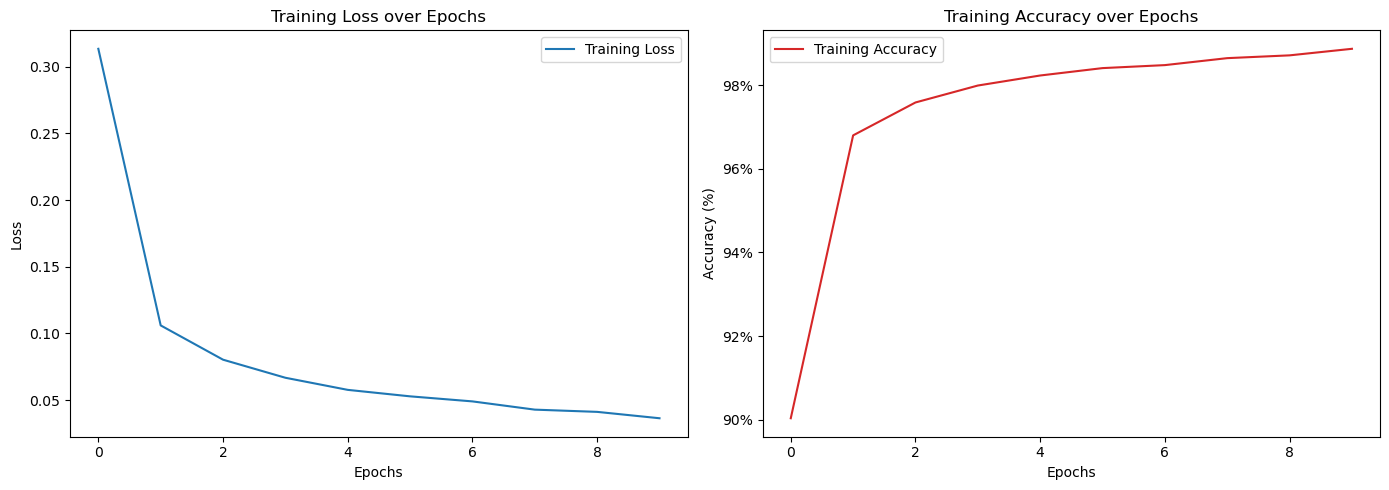

In [10]:
# 绘制训练损失和准确率图像
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# 绘制训练损失
ax1.plot(train_losses, label='Training Loss', color='tab:blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.legend()
# 绘制训练准确率
ax2.plot(train_accuracies, label='Training Accuracy', color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy over Epochs')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
ax2.legend()
plt.tight_layout()  # 调整布局
plt.show()

In [18]:
# 测试模型
correct = 0  # 初始化正确预测数
total = 0  # 初始化总数
with torch.no_grad():  # 禁用梯度计算
    for data in testloader:  # 遍历测试数据集
        inputs, labels = data  # 获取输入数据和标签
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移动到GPU上
        outputs = net(inputs)  # 前向传播
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += labels.size(0)  # 更新总数
        correct += (predicted == labels).sum().item()  # 更新正确预测数
print(f'Accuracy of the network on the 10000 test inputs: {100 * correct / total}%')  # 打印测试集上的准确率


Accuracy of the network on the 10000 test inputs: 98.45%
